In [1]:
from cell_env import CellEnv
# Use sb3 env checker:
from stable_baselines3.common.env_checker import check_env



In [2]:
env = CellEnv()
check_env(env)
env.reset()

(array([0.691, 0.691], dtype=float32), {})

In [3]:
env.step(0)

(array([0.691    , 0.7936746], dtype=float32),
 -0.2770674644894964,
 False,
 False,
 {})

In [4]:
env.step(1)

(array([0.7936746, 0.6996503], dtype=float32),
 0.25218595167296165,
 False,
 False,
 {})

In [5]:
from stable_baselines3 import PPO, DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from gymnasium.wrappers import TimeLimit


# eval wrapper:
env = TimeLimit(env, 100)
# use the monitor wrapper to log the results:
from stable_baselines3.common.monitor import Monitor
env = Monitor(env)
# model = PPO("MlpPolicy", DummyVecEnv([lambda: TimeLimit(env, 10)]), verbose=4)
model = DQN("MlpPolicy", DummyVecEnv([lambda: env]), verbose=4, tensorboard_log="./rl-logs/",
            exploration_fraction=0.5
model.learn(total_timesteps=50000, tb_log_name="dqn")


Using cpu device
Logging to ./rl-logs/dqn_1
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | -2.75    |
|    exploration_rate | 0.924    |
| time/               |          |
|    episodes         | 4        |
|    fps              | 840      |
|    time_elapsed     | 0        |
|    total_timesteps  | 400      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss             | 0.0084   |
|    n_updates        | 74       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 100      |
|    ep_rew_mean      | -2.54    |
|    exploration_rate | 0.848    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 818      |
|    time_elapsed     | 0        |
|    total_timesteps  | 800      |
| train/              |          |
|    learning_rate    | 0.0001   |
|    loss  

In [6]:
# run an episode:
obs = env.reset()
done = False
env = TimeLimit(env, 10)
obs, _ = env.reset()
total_reward = []
observations = []
while not done:
    action, _states = model.predict(obs)
    obs, rewards, term,trunc, info = env.step(action)
    print(obs)
    done=term or trunc
    total_reward.append(rewards)
    observations.append(obs)

[0.552     0.6340208]
[0.6340208 0.5589102]
[0.5589102 0.6309291]
[0.6309291 0.5651885]
[0.5651885  0.62843895]
[0.62843895 0.57091355]
[0.57091355 0.6264768 ]
[0.6264768 0.5761542]
[0.5761542 0.6249783]
[0.6249783  0.58097064]


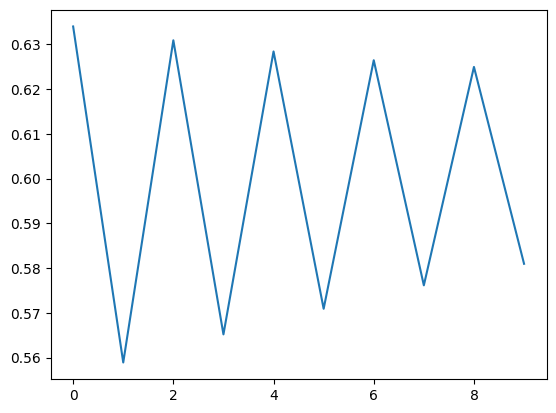

In [7]:
import matplotlib.pyplot as plt
# plt.plot(total_reward)
plt.figure()
plt.plot([ob[1] for ob in observations])

In [8]:
observations

[array([0.552    , 0.6340208], dtype=float32),
 array([0.6340208, 0.5589102], dtype=float32),
 array([0.5589102, 0.6309291], dtype=float32),
 array([0.6309291, 0.5651885], dtype=float32),
 array([0.5651885 , 0.62843895], dtype=float32),
 array([0.62843895, 0.57091355], dtype=float32),
 array([0.57091355, 0.6264768 ], dtype=float32),
 array([0.6264768, 0.5761542], dtype=float32),
 array([0.5761542, 0.6249783], dtype=float32),
 array([0.6249783 , 0.58097064], dtype=float32)]

In [9]:
# run an episode:
import numpy as np


obs = env.reset()
done = False
env = TimeLimit(env, 10)
obs, _ = env.reset()
total_reward = []
while not done:
    action = np.random.randint(0, env.action_space.n)
    obs, rewards, term,trunc, info = env.step(action)
    done=term or trunc
    total_reward.append(obs[1])


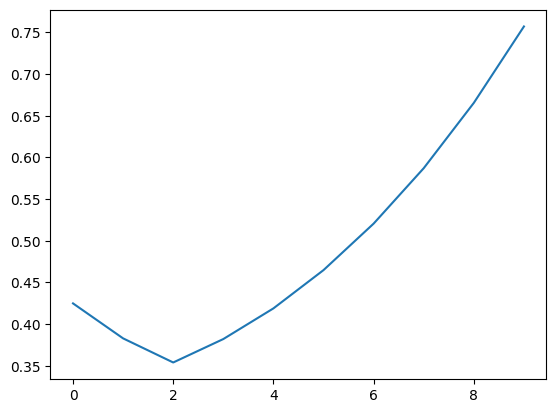

In [10]:
plt.plot(total_reward)